In [1]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import cv2
from typing import List
import matplotlib.pyplot as plt

In [2]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='best.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /Users/scotttw/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-2-18 Python-3.10.10 torch-2.2.0 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [24]:
# Load model
_MODEL_PATH = 'best.pt'
model = torch.hub.load('ultralytics/yolov5', 'custom', path=_MODEL_PATH, force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /Users/scotttw/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-2-18 Python-3.10.10 torch-2.2.0 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [64]:
# Define the inference function
def run_inference(image_np, size=640):
    image = Image.fromarray(image_np)
    resize = transforms.Resize((size, size))
    image = resize(image)
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add a batch dimension
    with torch.no_grad():
        results = model(image_tensor)
    return results, np.asarray(image).copy()  # Bounding boxes, confidences, and class predictions

_CONFIDENCE_THRESHOLD = 0.2
def filter_detections(detections):
    # Convert PyTorch tensor to numpy array if it's not already an array
    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()
    
    # Filter out detections below the confidence threshold
    # The shape of detections is expected to be (1, num_detections, 6) based on the error message
    # We first squeeze out the single batch dimension and then apply the threshold
    detections = detections.squeeze(0)
    filtered_detections = detections[detections[:, 4] >= _CONFIDENCE_THRESHOLD]

    if not list(filtered_detections):
        return -1
    max_detection = filtered_detections[0]
    for detection in filtered_detections:
        if detection[4] > max_detection[4]:
            max_detection = detection
    
    return max_detection

def get_bounding_box_from_detection(detection):
    return [int(detection[0]), int(detection[1]), int(detection[2]), int(detection[3])]

def draw_bounding_box_on_image(image: np.ndarray, bbox: List[float]):
  """Draw bounding boxes on an image.
  
  Args:
    image: HxWx3 np array image
    bbox: List of 4 floats in the format (center_x, center_y, width, height)
  """
  height, width, _ = image.shape
  cx, cy = bbox[0], bbox[1]
  h,w = bbox[2], bbox[3]

  top_left = (cx - w // 2, cy - h // 2)
  bottom_right = (cx + w // 2, cy + h // 2)

  # Draw rectangle on image. Note that OpenCV uses top-left and bottom-right points of the rectangle.
  cv2.rectangle(
      image,
      top_left,
      bottom_right,
      color=(255, 0, 0),
      thickness=2
  )
  return image

def inference_on_image(image: np.ndarray) -> np.ndarray:
  oh, ow, _ = image.shape

  results, resized_image = run_inference(image)
  rh, rw, _ = resized_image.shape

  detection = filter_detections(results)
  if not isinstance(detection, np.ndarray):
    print('No detection')
    return image

  bbox = get_bounding_box_from_detection(detection)
  bbox[0] = int(bbox[0] * ow / rw)
  bbox[1] = int(bbox[1] * oh / rh)
  bbox[2] = int(bbox[2] * ow / rw)
  bbox[3] = int(bbox[3] * oh / rh)
  
  return draw_bounding_box_on_image(image.copy(), bbox)

In [71]:
example_image = np.asarray(Image.open('Database1/15.JPEG'))
results, image = run_inference(example_image)
detection = filter_detections(results)
bbox = get_bounding_box_from_detection(detection)
img = draw_bounding_box_on_image(image, bbox)


In [66]:
print(bbox)

[318, 261, 178, 152]


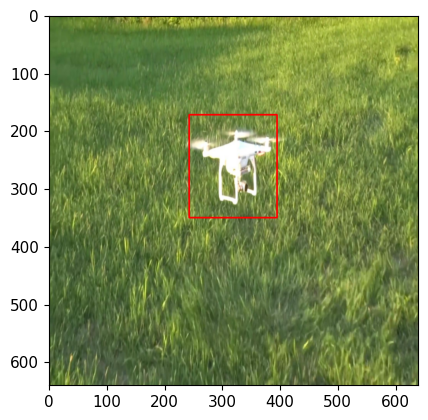

In [67]:
plt.imshow(img)

In [68]:
def inference_on_image(image: np.ndarray) -> np.ndarray:
  oh, ow, _ = image.shape

  results, resized_image = run_inference(image)
  rh, rw, _ = resized_image.shape

  detection = filter_detections(results)
  if not isinstance(detection, np.ndarray):
    print('No detection')
    return image

  bbox = get_bounding_box_from_detection(detection)
  bbox[0] = int(bbox[0] * ow / rw)
  bbox[1] = int(bbox[1] * oh / rh)
  bbox[2] = int(bbox[2] * ow / rw)
  bbox[3] = int(bbox[3] * oh / rh)
  
  return draw_bounding_box_on_image(image.copy(), bbox)

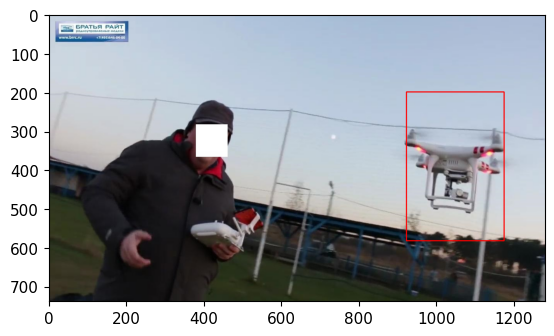

In [72]:
plt.imshow(inference_on_image(example_image))

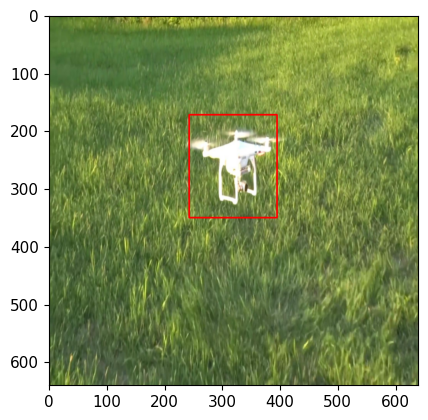

In [63]:
%matplotlib inline
plt.imshow(img)
plt.show()

In [76]:
from IPython.display import display, clear_output
import cv2
import time

# Initialize the webcam (use 0 for default webcam)
cap = cv2.VideoCapture(1)

# Check if the webcam is opened successfully
if not cap.isOpened():
    raise IOError("Cannot open webcam")

try:
    while True:
        # Capture one frame
        ret, frame = cap.read()
        
        # Check if the frame is returned successfully
        if not ret:
            raise IOError("Cannot capture image from webcam")
        
        # Convert the image from BGR (OpenCV format) to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # frame = inference_on_image(frame)

        
        # Use PIL to convert array to Image
        from PIL import Image
        pil_img = Image.fromarray(frame)
        
        # Display the image in the Jupyter Notebook
        clear_output(wait=True)
        display(pil_img)
        
        # # Wait for a short period to control the frame rate
        # time.sleep(0.1)

except KeyboardInterrupt:
    # Release the webcam when interrupted
    cap.release()
    print("Stream stopped.")
finally:
    cap.release()

Stream stopped.
